In [1]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 67.9 MB/s 
     |████████████████████████████████| 61 kB 506 kB/s 
     |████████████████████████████████| 895 kB 80.7 MB/s 
     |████████████████████████████████| 596 kB 76.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import re
import os
import urllib.request
from tqdm import tqdm
from transformers import BertTokenizer, TFBertForSequenceClassification

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x7f3c09946a10>)

In [4]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [5]:
data

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,neutral,Rinkuskiai's beer sales fell by 6.5 per cent t...,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,negative,Net sales of the Paper segment decreased to EU...,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [6]:
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
data[:5]

,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [7]:
del data['sentence']

In [8]:
data[:5]

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [10]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [11]:
print('kor_sentence 열의 유니크한 값 :',data['kor_sentence'].nunique())

kor_sentence 열의 유니크한 값 : 4827


In [12]:
duplicate = data[data.duplicated()]

In [13]:
duplicate

,labels,kor_sentence
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.
1394,0,"핀란드 헬싱키에 본사를 둔 레민카이넨 그룹은 토목 공학, 건축 계약, 기술 건축 서..."
1416,0,"이 보고서는 블랙 앤 데커, 피스카스, 피스카스 브랜드, 후스크바르나 아웃도어 프로..."
2396,0,알스트롬의 주가는 나스닥 OMX 헬싱키에서 인용되고 있다.
2567,0,SSH 통신 보안 코퍼레이션은 핀란드 헬싱키에 본사를 두고 있다.
2889,0,재정적인 세부사항은 공개되지 않았다.
2890,0,재정적인 세부사항은 공개되지 않았다.
2892,0,금융 조건은 공개되지 않았다.
3050,0,재정적인 세부사항은 제공되지 않았다.
3051,0,재정적인 세부사항은 공개되지 않았다.


In [14]:
# 중복 제거
data.drop_duplicates(subset=['kor_sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4827


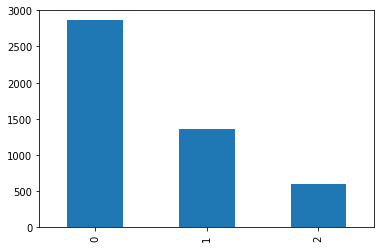

In [15]:
data['labels'].value_counts().plot(kind='bar')

In [16]:
print('레이블의 분포')
print(data.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0       0   2861
1       1   1362
2       2    604


In [17]:
print(f'중립의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')

중립의 비율 = 59.271%
긍정의 비율 = 28.216%
부정의 비율 = 12.513%


In [18]:
data

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...
4841,2,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,0,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,2,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,2,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [19]:
X_data = data['kor_sentence']
y_data = data['labels']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4827
레이블의 개수: 4827


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [21]:
print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_test))

훈련 샘플의 개수 : 3861
테스트 샘플의 개수 : 966


In [22]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 59.285%
긍정 = 28.205%
부정 = 12.51%


In [23]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 59.213%
긍정 = 28.261%
부정 = 12.526%


In [26]:
max_seq_len = 128

In [29]:
tokenizer = BertTokenizer.from_pretrained('klue/bert-base')

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [24]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)

        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스.
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count

        # token_type_id은 세그먼트 인코딩
        token_type_id = [0] * max_seq_len

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [30]:
train_X, train_y = convert_examples_to_features(X_train, y_train, max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/3861 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 3861/3861 [00:01<00:00, 2012.31it/s]


In [31]:
test_X, test_y = convert_examples_to_features(X_test, y_test, max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/966 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 966/966 [00:00<00:00, 2198.17it/s]


In [32]:
input_id = train_X[0][0]
attention_mask = train_X[1][0]
token_type_id = train_X[2][0]
label = train_y[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [    2  4048  2063  2259 10735  2147  2227  2079  8660 27135 10735  2147
  4401  4286  2205  2259  4946  2052  4169  2085   575  6233  4045 19521
  1513  2062    18     3     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [73]:
# TPU 작동을 위한 코드
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.43.175.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.43.175.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [74]:
with strategy.scope():
  model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=3, from_pt=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  model.compile(optimizer=optimizer, loss=model.compute_loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
early_stopping = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001,
    patience=2)

model.fit(
    train_X, train_y, epochs=2, batch_size=32, validation_split=0.2,
    callbacks = [early_stopping]
)

Epoch 1/2


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int32>]


97/97 [==============================] - ETA: 0s - loss: 0.5257 - accuracy: 0.7821

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int32>]


97/97 [==============================] - 156s 755ms/step - loss: 0.5257 - accuracy: 0.7821 - val_loss: 0.4156 - val_accuracy: 0.8228
Epoch 2/2
97/97 [==============================] - 8s 86ms/step - loss: 0.2479 - accuracy: 0.9113 - val_loss: 0.4751 - val_accuracy: 0.8072


In [64]:
model.evaluate(test_X, test_y, batch_size=1024)

1/1 [==============================] - 8s 8s/step - loss: 0.4006 - accuracy: 0.8582


[0.4006069004535675, 0.8581780791282654]